In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
import numpy as np

In [2]:
file_path = 'data/predicted_route_all_new_routes_source_extended.csv'
data = pd.read_csv(file_path)
data.shape

(14185, 33)

In [3]:
central_mediterranean_data = data[data['migration_route'] =='Central Mediterranean']
central_mediterranean_data

,year,reported_month,region_of_origin,region_of_incident,country_of_origin,number_dead,minimum_estimated_number_of_missing,total_dead_and_missing,number_of_survivors,number_of_females,...,dehydration_malnutrition,drowning,environmental_factors,lack_of_access_to_healthcare,murder_violence,sexual_abuse_rape,suicide,unknown,war_related,main_cause
74,2015,8,Western Asia,Europe,"Afghanistan,Iraq,Syrian Arab Republic,Unknown",71.0,0.0,71,0.0,8.0,...,0,0,0,0,0,0,0,0,0,accident
149,2015,12,Eastern Africa,Europe,Eritrea,1.0,0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,accident
206,2016,3,Northern Africa,Europe,Egypt,1.0,0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,accident
352,2016,11,Eastern Africa,Europe,Eritrea,1.0,0.0,1,0.0,1.0,...,0,0,0,0,0,0,0,0,0,accident
360,2016,11,Eastern Africa,Europe,Eritrea,1.0,0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14161,2014,4,Unknown,Mediterranean,Unknown,8.0,1.0,9,5.0,2.0,...,0,0,0,0,0,0,0,0,0,drowning
14163,2014,4,Unknown,Mediterranean,Unknown,1.0,0.0,1,661.0,0.0,...,0,0,0,0,0,0,0,0,0,unknown
14168,2014,3,Unknown,Mediterranean,Unknown,1.0,0.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,asphyxiation_suffocation
14175,2014,2,Unknown,Mediterranean,Unknown,7.0,0.0,7,0.0,0.0,...,0,0,0,0,0,0,0,0,0,drowning


# 1. Most common countries of origin

In [4]:
# Extract unique country names from the 'country_of_origin' column in the Central Mediterranean data
unique_country_names = central_mediterranean_data['country_of_origin'].str.split(',').explode().str.strip().unique()
unique_country_names.sort()
unique_country_names

array(['Afghanistan', 'Algeria', 'Bangladesh', 'Benin', 'Burkina Faso',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Egypt',
       'Eritrea', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Iraq', 'Kyrgyzstan', 'Libya', 'Mali',
       'Mauritania', 'Mexico', 'Mixed', 'Mixed/Unknown', 'Morocco',
       'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Palestinian Territories',
       'Papua New Guinea', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Sudan', 'State of Palestine', 'Sudan',
       'Syrian Arab Republic', 'Togo', 'Tunisia', 'Türkiye', 'Unknown',
       'Zambia'], dtype=object)

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7847/3594251433.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


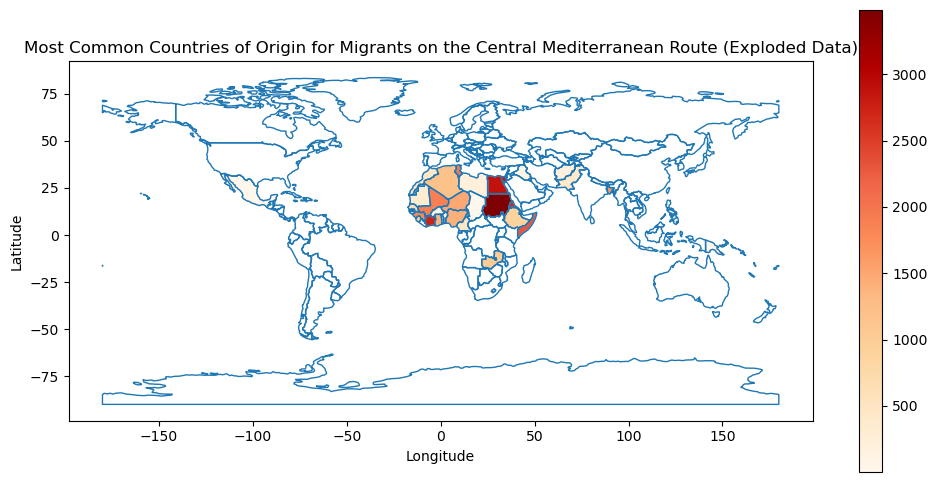

In [5]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Explode the 'country_of_origin' column so that each row contains only one country name
exploded_countries_data = central_mediterranean_data.assign(country_of_origin=central_mediterranean_data['country_of_origin'].str.split(',')).explode('country_of_origin').reset_index(drop=True)

# Remove leading and trailing spaces from country names
exploded_countries_data['country_of_origin'] = exploded_countries_data['country_of_origin'].str.strip()

# Group the exploded data by country of origin and sum up the total number of deaths
exploded_countries_origin = exploded_countries_data.groupby('country_of_origin')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False)

# Merge the world map with the exploded Central Mediterranean data
world_merged_exploded = world.set_index('name').join(exploded_countries_origin.set_index('country_of_origin'))

# Plot the map
fig, ax = plt.subplots(1, figsize=(12, 6))
world.boundary.plot(ax=ax, linewidth=1)
world_merged_exploded.plot(column='total_dead_and_missing', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Most Common Countries of Origin for Migrants on the Central Mediterranean Route (Exploded Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


The map visualizes the most common countries of origin for migrants on the Central Mediterranean route, based on the exploded data. Each country is shaded according to the total number of dead and missing individuals originating from there. The darker the shade, the higher the number of lives lost.

#### Key Points
The map provides a more accurate geographical context, allowing for better-targeted interventions and diplomatic efforts.

# 2. Deadliest Segments of the Route

/var/folders/kh/5kbp140j0wg8j3d9nrllg18h0000gn/T/ipykernel_7847/2532829140.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


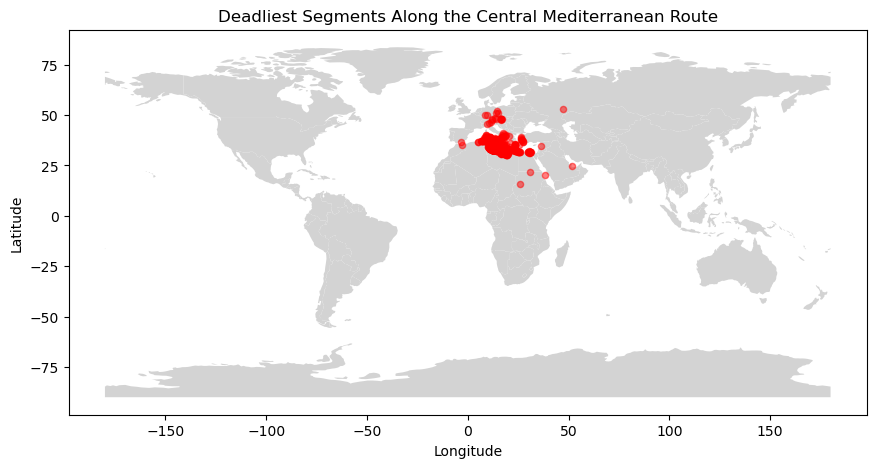

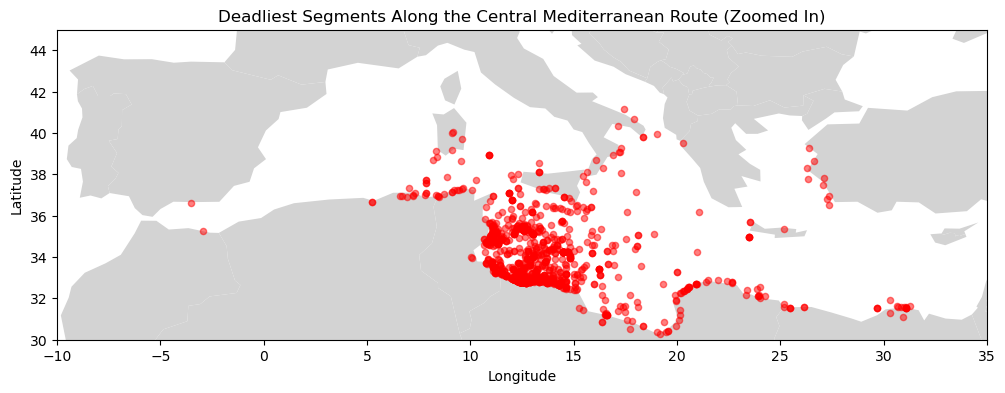

In [6]:
# Create a GeoDataFrame from the latitude and longitude columns
gdf = gpd.GeoDataFrame(central_mediterranean_data, geometry=gpd.points_from_xy(central_mediterranean_data.lon, central_mediterranean_data.lat))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map and overlay the incident points
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=20, color='red', alpha=0.5)
plt.title('Deadliest Segments Along the Central Mediterranean Route')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Zoom into the Mediterranean area by setting x and y limits
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=20, color='red', alpha=0.5)

# Set latitude and longitude bounds for the plot
ax.set_xlim([-10, 35])
ax.set_ylim([30, 45])

plt.title('Deadliest Segments Along the Central Mediterranean Route (Zoomed In)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [7]:
import folium
from folium.plugins import MarkerCluster

# Create a map centered around the Mediterranean area
m = folium.Map(location=[37, 15], zoom_start=6)

# Add different map tile sources (choose the one you prefer)
folium.TileLayer('Stamen Terrain').add_to(m)
# You can add more tile layers or choose the one that fits your style

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Iterate through your incident data and add markers
for index, row in central_mediterranean_data.iterrows():
    lat, lon = row['lat'], row['lon']
    incident_description = row['total_dead_and_missing']  # Replace with your incident description

    # Add a custom marker with a red icon for incidents
    folium.Marker([lat, lon], popup=incident_description,
                  icon=folium.Icon(color='red', icon='info-sign')).add_to(marker_cluster)

# Display the map
m.save('central_mediterranean_incidents_map.html')  # Save as HTML file
m


The zoomed-in map provides a closer look at the deadliest segments along the Central Mediterranean route, indicated by the red points. This focused view allows us to better identify the geographic hotspots where the most incidents have occurred.

#### Key Points
The zoomed-in perspective helps us pinpoint areas that may require immediate attention and intervention.
These hotspots could be the focus of rescue operations, surveillance, and other preventative measures.

/Users/lilitdavidyan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


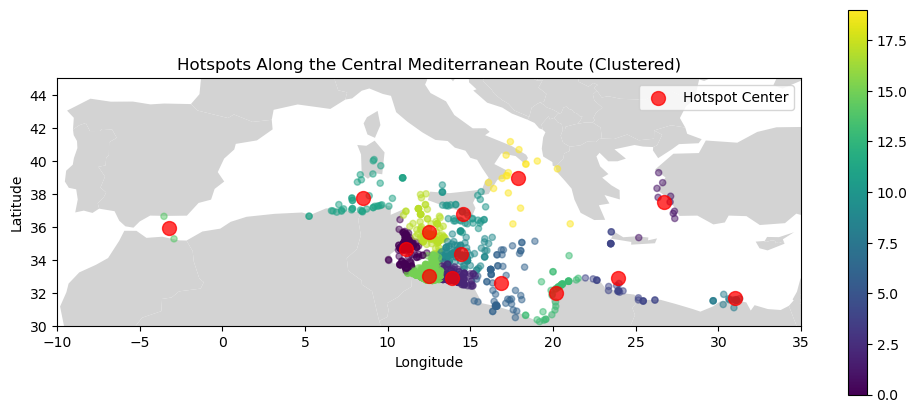

In [8]:
# Drop rows with missing lat/lon information
gdf_dropped_na = gdf.dropna(subset=['lat', 'lon'])

# Prepare the data for clustering
coordinates = gdf_dropped_na[['lat', 'lon']].values

# Perform k-means clustering to identify hotspots
kmeans = KMeans(n_clusters=20, random_state=0).fit(coordinates)
gdf_dropped_na['cluster'] = kmeans.labels_

# Plot the world map, overlay the incident points, and highlight the cluster centers
fig, ax = plt.subplots(1, figsize=(12, 5))
world.plot(ax=ax, color='lightgrey')
gdf_dropped_na.plot(ax=ax, markersize=20, column='cluster', legend=True, cmap='viridis', alpha=0.5)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', s=100, alpha=0.75, label='Hotspot Center')
plt.legend()

# Set latitude and longitude bounds for the plot
ax.set_xlim([-10, 35])
ax.set_ylim([30, 45])

plt.title('Hotspots Along the Central Mediterranean Route (Clustered)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


#### Key Points
These locations could be prioritized for rescue operations, surveillance, and other preventative measures.

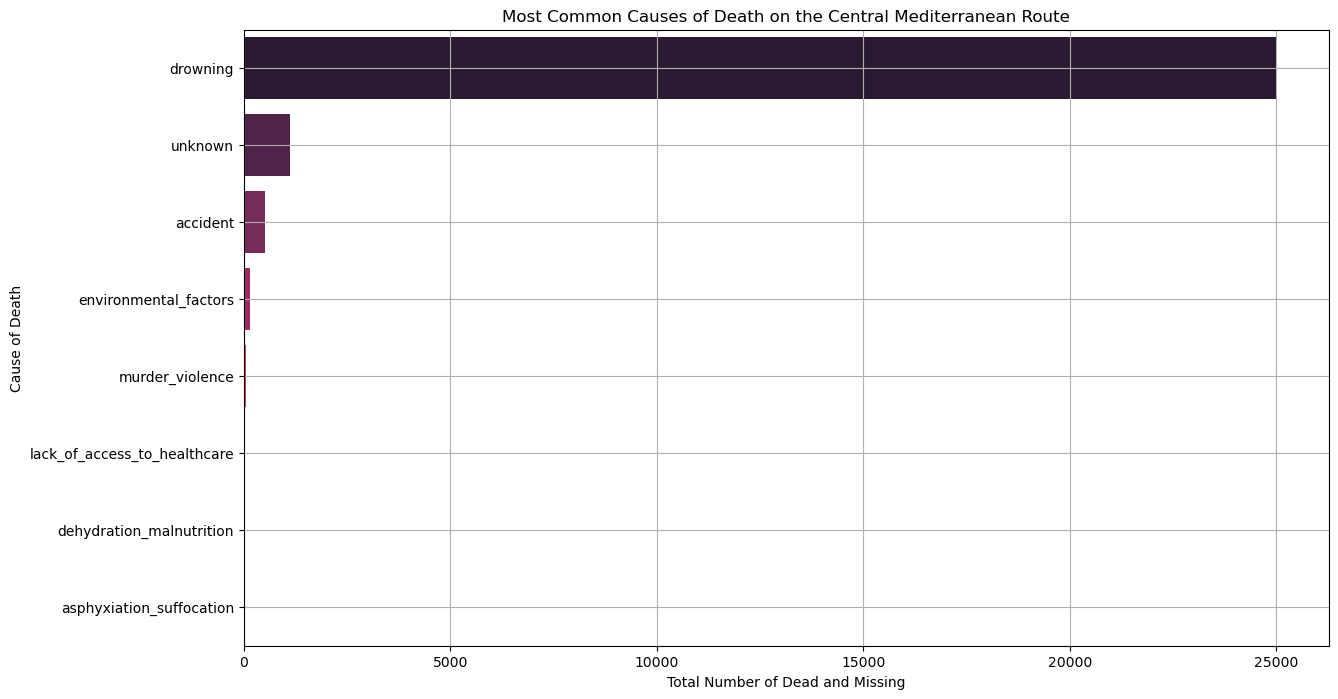

In [9]:
# Group the data by cause of death and sum up the total number of deaths for each cause
cause_of_death_data = central_mediterranean_data.groupby('main_cause')['total_dead_and_missing'].sum().reset_index().sort_values(by='total_dead_and_missing', ascending=False).head(10)

# Create a bar plot to visualize the most common causes of death on the Central Mediterranean route
plt.figure(figsize=(14, 8))
sns.barplot(x='total_dead_and_missing', y='main_cause', data=cause_of_death_data, palette='rocket')
plt.title('Most Common Causes of Death on the Central Mediterranean Route')
plt.xlabel('Total Number of Dead and Missing')
plt.ylabel('Cause of Death')
plt.grid(True)
plt.show()


#### Key Points
- Drowning is by far the most common cause of death, followed by other causes like dehydration and hypothermia.
- Understanding these common causes can help in planning targeted interventions such as providing life vests, water, or emergency medical care.
- This information can also be used to inform public awareness campaigns aimed at potential migrants, letting them know the risks involved.

# 3. Demographic Distribution

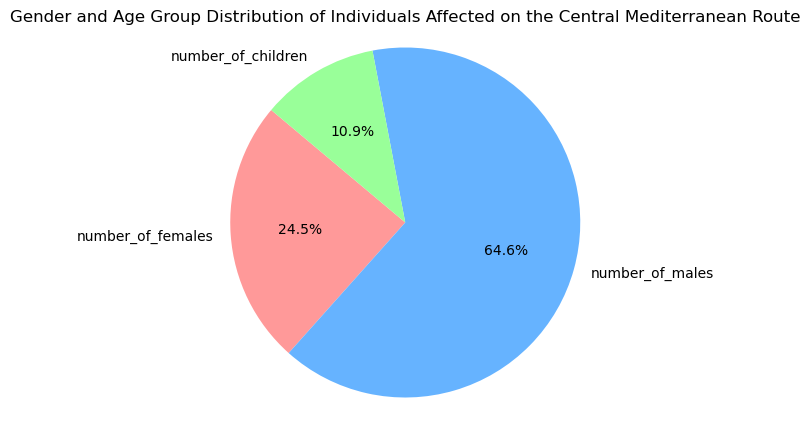

,Demographic Group,Percentage (%)
0,number_of_females,24.511247
1,number_of_males,64.599538
2,number_of_children,10.889216


In [10]:
# Sum up the number of females, males, and children involved in incidents on the Central Mediterranean route
demographic_summary = central_mediterranean_data[['number_of_females', 'number_of_males', 'number_of_children']].sum().reset_index()
demographic_summary.columns = ['Demographic Group', 'Total Number']

# Calculate the percentage distribution for gender
total_individuals = demographic_summary['Total Number'].sum()
demographic_summary['Percentage (%)'] = (demographic_summary['Total Number'] / total_individuals) * 100

# Create a pie chart to visualize the gender distribution
plt.figure(figsize=(6, 5))
plt.pie(demographic_summary['Percentage (%)'], labels=demographic_summary['Demographic Group'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Gender and Age Group Distribution of Individuals Affected on the Central Mediterranean Route')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

demographic_summary[['Demographic Group', 'Percentage (%)']]


#### Key Points:
- Males constitute the majority, making up approximately 64.6% of the total individuals affected.
- Females represent about 24.5%.
- Children account for approximately 10.9%.

# 4. Temporal Trends: Seasonal and Annual Variations

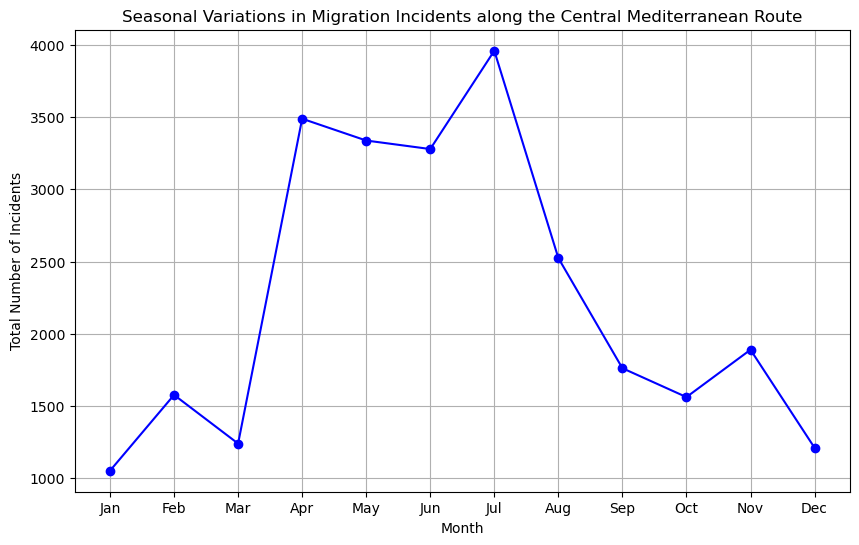

In [11]:
# Group the data by month and calculate the total number of incidents for each month
monthly_incident_counts = central_mediterranean_data.groupby('reported_month')['total_dead_and_missing'].sum()

# Plot the seasonal variations in incidents
plt.figure(figsize=(10, 6))
monthly_incident_counts.plot(kind='line', marker='o', color='b')
plt.title('Seasonal Variations in Migration Incidents along the Central Mediterranean Route')
plt.xlabel('Month')
plt.ylabel('Total Number of Incidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


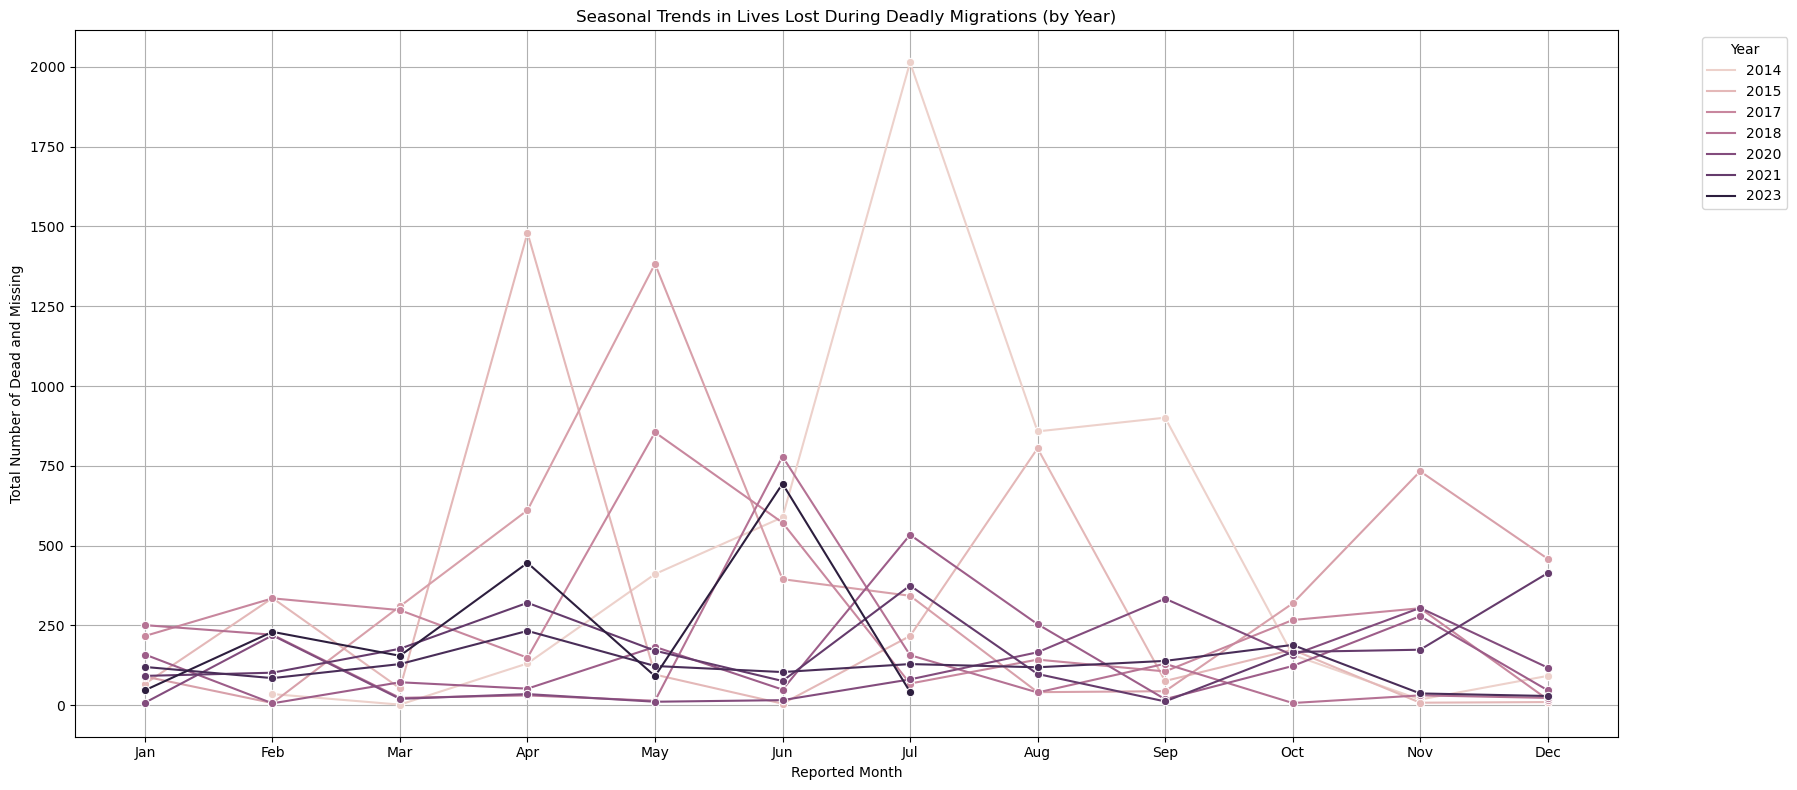

In [12]:
# Group the data by reported month and year, then sum up the total number of deaths
monthly_yearly_deaths = central_mediterranean_data.groupby(['reported_month', 'year'])['total_dead_and_missing'].sum().reset_index()

# Create a line plot to visualize the trend over the months and years
plt.figure(figsize=(18, 8))
sns.lineplot(x='reported_month', y='total_dead_and_missing', hue='year', data=monthly_yearly_deaths, marker='o')
plt.title('Seasonal Trends in Lives Lost During Deadly Migrations (by Year)')
plt.xlabel('Reported Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


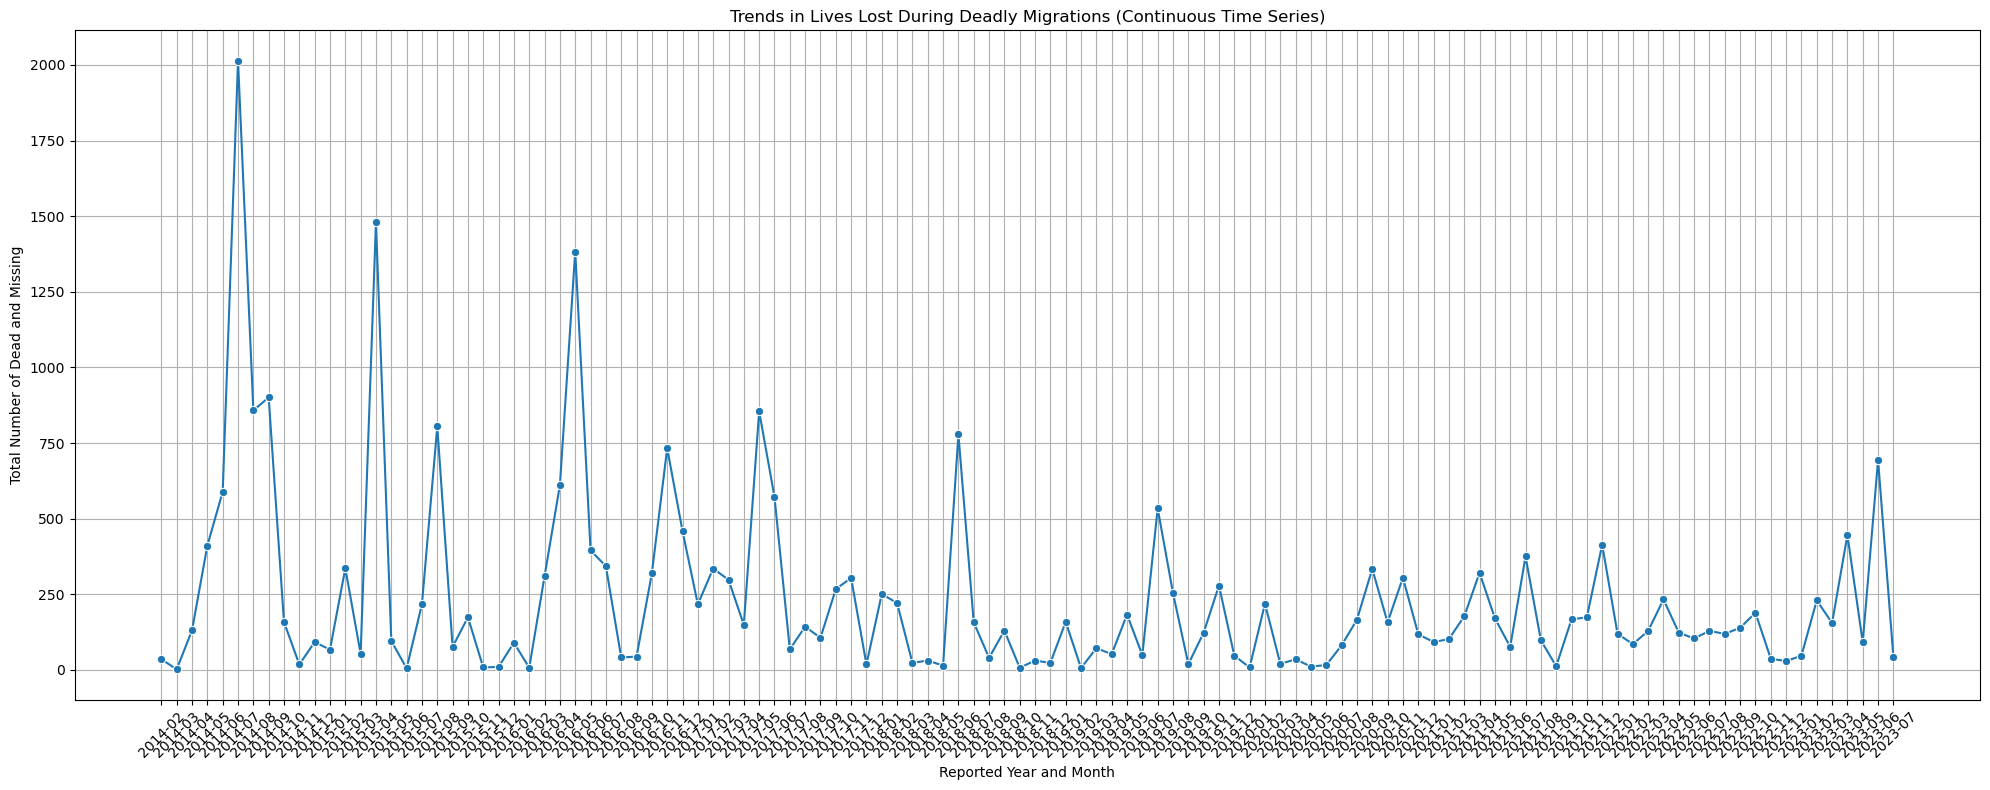

In [13]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Create a line plot to visualize the trend over all months and years
plt.figure(figsize=(20, 8))
sns.lineplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, marker='o')
plt.title('Trends in Lives Lost During Deadly Migrations (Continuous Time Series)')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


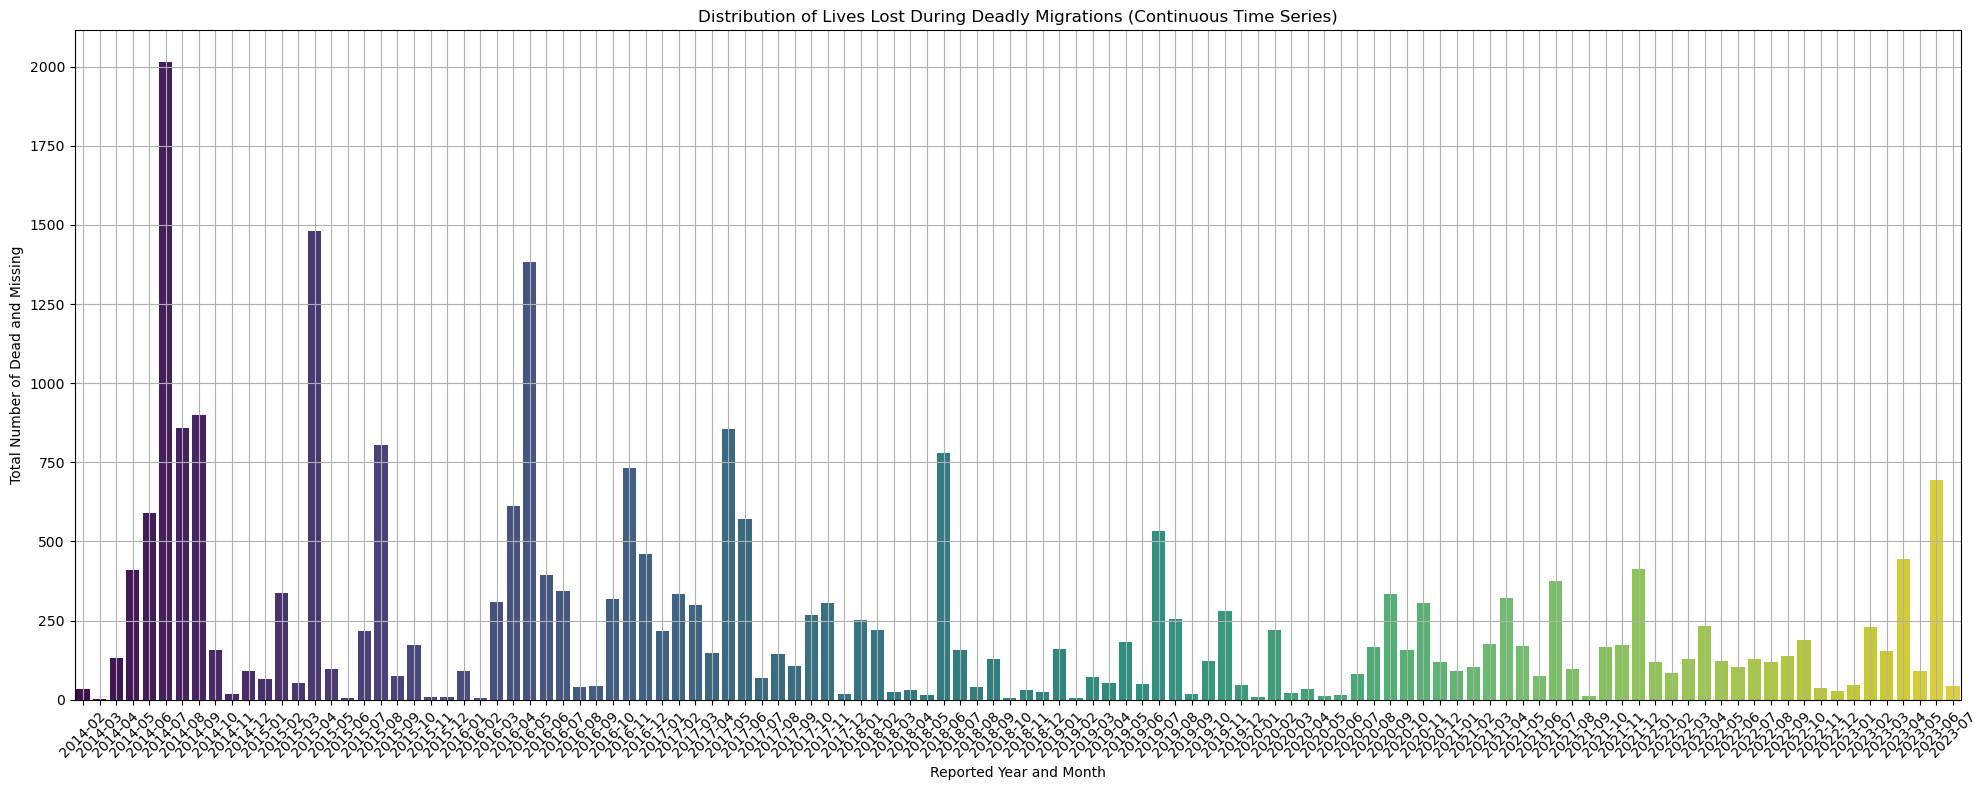

In [16]:

# Create a bar plot to visualize the distribution over all months and years
plt.figure(figsize=(20, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')
plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series)')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

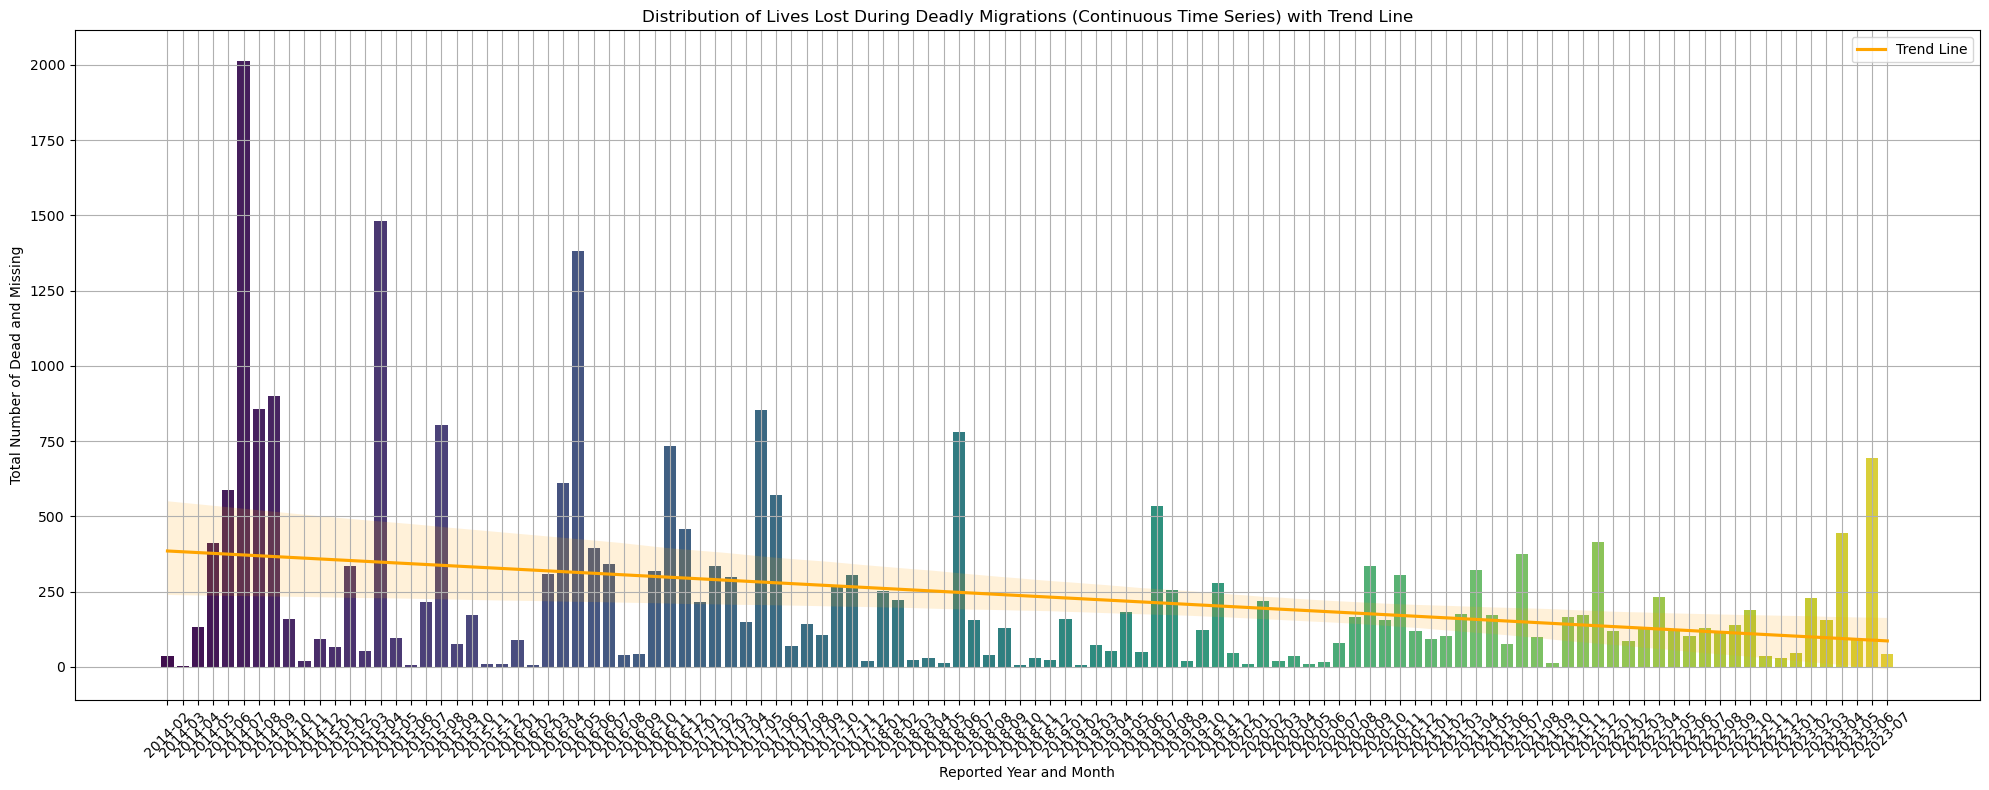

In [17]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Create a new column with sequential integers for x-values
monthly_yearly_deaths['x_values'] = np.arange(len(monthly_yearly_deaths))

# Create a bar plot with a trend line
plt.figure(figsize=(20, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')
sns.regplot(x='x_values', y='total_dead_and_missing', data=monthly_yearly_deaths, scatter=False, color='orange', label='Trend Line')
plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series) with Trend Line')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

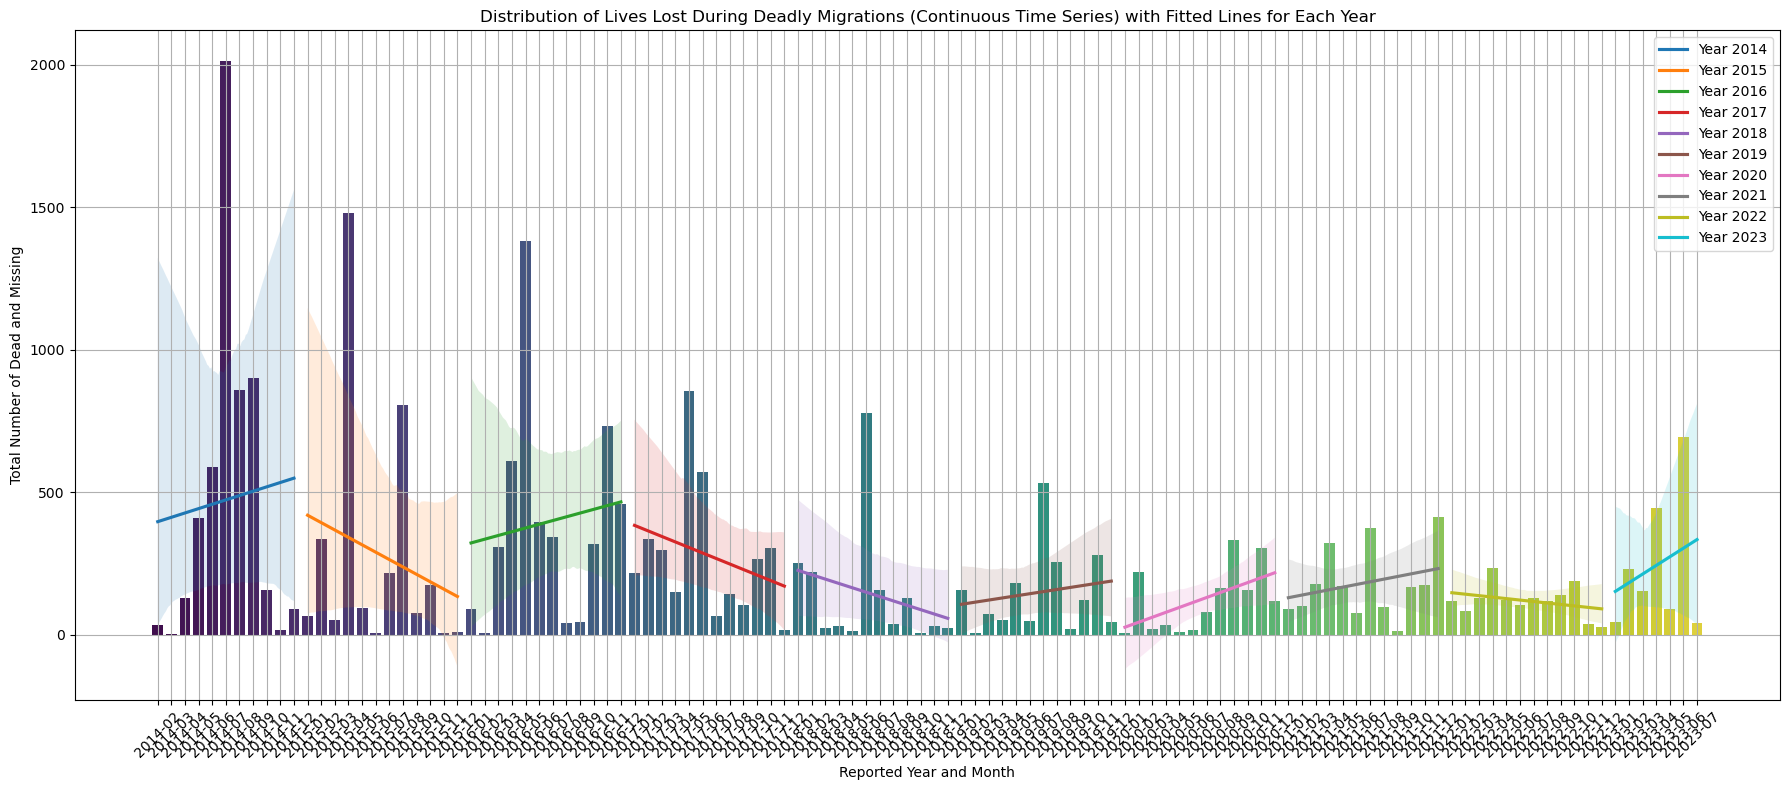

In [18]:
# Create a new column combining the year and month for a continuous time series
monthly_yearly_deaths['year_month'] = monthly_yearly_deaths['year'].astype(str) + '-' + monthly_yearly_deaths['reported_month'].astype(str).str.zfill(2)

# Sort the DataFrame by the year_month column
monthly_yearly_deaths = monthly_yearly_deaths.sort_values('year_month')

# Calculate average values for each year
average_deaths_yearly = monthly_yearly_deaths.groupby('year')['total_dead_and_missing'].mean().reset_index()

# Create a bar plot with fitted lines for each year
plt.figure(figsize=(18, 8))
sns.barplot(x='year_month', y='total_dead_and_missing', data=monthly_yearly_deaths, palette='viridis')

# Plot fitted lines for each year
for year in monthly_yearly_deaths['year'].unique():
    year_data = monthly_yearly_deaths[monthly_yearly_deaths['year'] == year]
    sns.regplot(x='x_values', y='total_dead_and_missing', data=year_data, scatter=False, label=f'Year {year}')

plt.title('Distribution of Lives Lost During Deadly Migrations (Continuous Time Series) with Fitted Lines for Each Year')
plt.xlabel('Reported Year and Month')
plt.ylabel('Total Number of Dead and Missing')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

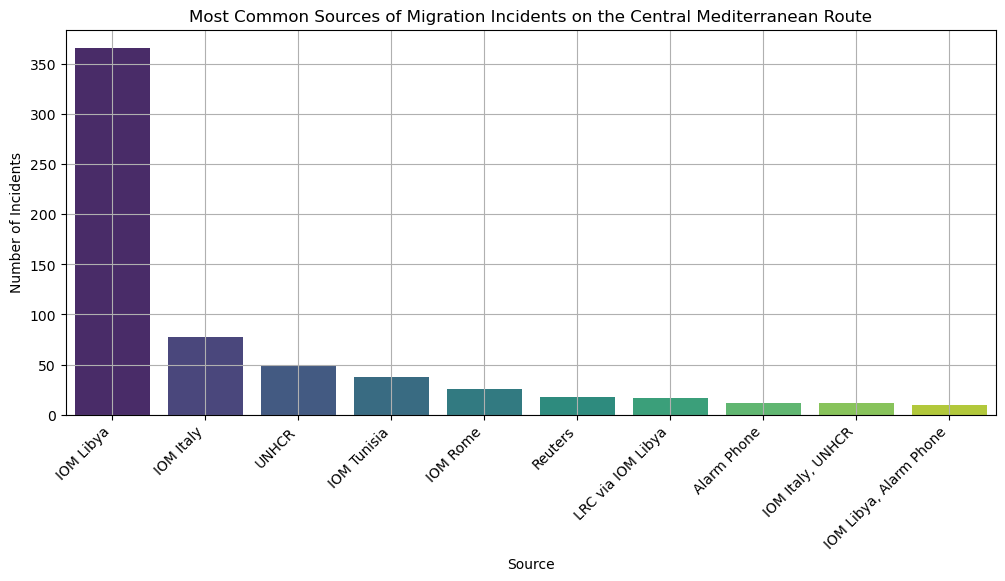

In [19]:
# Group the data by cause of death and sum up the total number of deaths for each cause
source_data = central_mediterranean_data['source'].value_counts().head(10)

# Reorder the source_data Series by the number of incidents in descending order
source_data = source_data.sort_values(ascending=False)

# Create a count plot
plt.figure(figsize=(12, 5))
sns.countplot(x='source',  
              data=central_mediterranean_data[central_mediterranean_data.source.isin(source_data.keys().tolist())],
              order=source_data.index,  # Specify the order of the bars
              palette='viridis')
plt.title('Most Common Sources of Migration Incidents on the Central Mediterranean Route')
plt.xlabel('Source')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

In [20]:
central_mediterranean_data['total_dead_and_missing'].sum()

26877